In [1]:
from denoiser import pretrained
from denoiser import utils
from IPython.display import Audio
import matplotlib.pyplot as plt
import numpy as np
import librosa
import torchaudio
import torch
import wave
import os

In [2]:
# import ipywidgets as widgets
# from IPython.display import display
# import torchaudio

# # Create an upload button
# upload_button = widgets.FileUpload(accept='.wav', multiple=False)

# # Function to handle the uploaded file
# def on_upload_change(change):
#     for filename, file_info in upload_button.value.items():
#         with open(filename, 'wb') as f:
#             f.write(file_info['content'])
#         print(f"Uploaded file: {filename}")
#         global audio_path
#         audio_path = filename

# # Attach the function to the upload button
# upload_button.observe(on_upload_change, names='value')

# # Display the upload button
# display(upload_button)

In [3]:
audio_path = './p287_003.wav'
clean_audio_path = './p287_003_clean.wav' 

In [4]:
def load_audio(audio_path):
    # Open the noisy and clean audio files using the wave library
    try:
        noisy_audio_file = wave.open(audio_path, 'rb')
        
        # Print details of the audio file
        print(f"{audio_path} details:")
        print(f"Channels: {noisy_audio_file.getnchannels()}")
        print(f"Sample width: {noisy_audio_file.getsampwidth()}")
        print(f"Frame rate (sample rate): {noisy_audio_file.getframerate()}")
        print(f"Number of frames: {noisy_audio_file.getnframes()}")

        # Read frames and store audio data
        noisy_audio_data = noisy_audio_file.readframes(noisy_audio_file.getnframes())

        # Close the files
        noisy_audio_file.close()
        
    except wave.Error as e:
        print(f"Error opening .wav file: {e}")


In [5]:
load_audio(audio_path)
load_audio(clean_audio_path)

./p287_003.wav details:
Channels: 1
Sample width: 2
Frame rate (sample rate): 16000
Number of frames: 115715
./p287_003_clean.wav details:
Channels: 1
Sample width: 2
Frame rate (sample rate): 16000
Number of frames: 115715


In [6]:
def plot_graph(file_path):
    # Open the .wav file
    with wave.open(file_path, 'r') as wav_file:
        # Extract Raw Audio from Wav File
        signal = wav_file.readframes(-1)
        signal = np.frombuffer(signal, dtype=np.int16)

        # Get the frame rate (sample rate)
        sample_rate = wav_file.getframerate()

        # Time axis in seconds
        times = np.linspace(0, len(signal) / sample_rate, num=len(signal))

        # Plot the waveform
        plt.figure(figsize=(10, 4))
        plt.plot(times, signal)
        plt.title("Waveform of the "+file_path+ " Audio")
        plt.ylabel("Amplitude")
        plt.xlabel("Time (s)")
        plt.show()


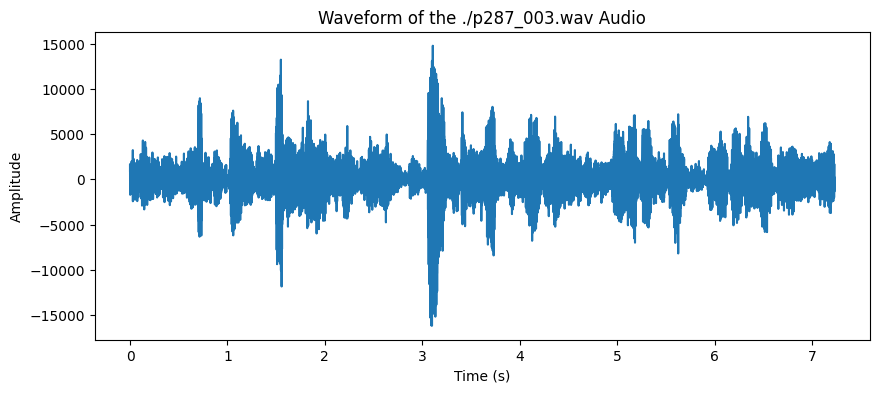

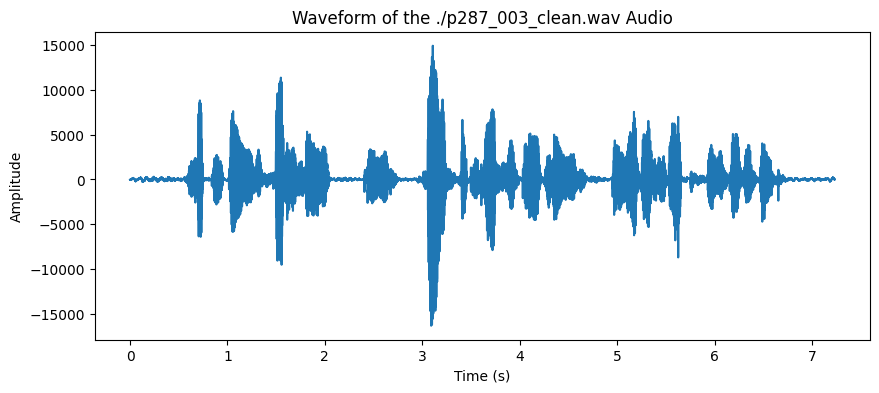

(None, None)

In [7]:
plot_graph(audio_path), plot_graph(clean_audio_path)

In [8]:
# Function to read a .wav file using the wave library
def read_wave_file(audio_path):
    with wave.open(audio_path, 'rb') as wav_file:
        sample_rate = wav_file.getframerate()
        num_frames = wav_file.getnframes()
        audio_data = wav_file.readframes(num_frames)
        audio_data = np.frombuffer(audio_data, dtype=np.int16)  # Assuming 16-bit PCM format
        # Normalize to range [-1, 1]
        audio_data = audio_data.astype(np.float32) / 32768.0
        return audio_data, sample_rate

In [9]:
# Function to save a .wav file using the wave library
def save_wave_file(output_path, audio_data, sample_rate):
    audio_data = (audio_data * 32768.0).astype(np.int16)  # Convert back to 16-bit PCM
    with wave.open(output_path, 'wb') as wav_file:
        wav_file.setnchannels(1)  # Assuming mono audio
        wav_file.setsampwidth(2)  # 2 bytes = 16 bits
        wav_file.setframerate(sample_rate)
        wav_file.writeframes(audio_data.tobytes())

In [10]:
# Load the audio file
noisy_waveform, sample_rate = read_wave_file(audio_path)

In [11]:
# Convert numpy array to tensor and add batch dimension
noisy_waveform = torch.from_numpy(noisy_waveform).unsqueeze(0)

In [12]:
# Load the pre-trained model (e.g., dns48 model)
model = pretrained.dns48()

In [13]:
# Denoise the audio
with torch.no_grad():
    denoised_waveform = model(noisy_waveform)

# Remove batch dimension and convert back to numpy array
denoised_waveform_np = denoised_waveform.squeeze(0).numpy()

In [14]:
# Save the denoised audio
output_path = "enhanced_audio.wav"
save_wave_file(output_path, denoised_waveform_np, sample_rate)

In [15]:
# Play the original and denoised audio (you might need to adapt this depending on the environment)
from IPython.display import Audio, display
print("Original Audio:")
display(Audio(audio_path))

print("Denoised Audio:")
display(Audio(output_path))

Original Audio:


Denoised Audio:


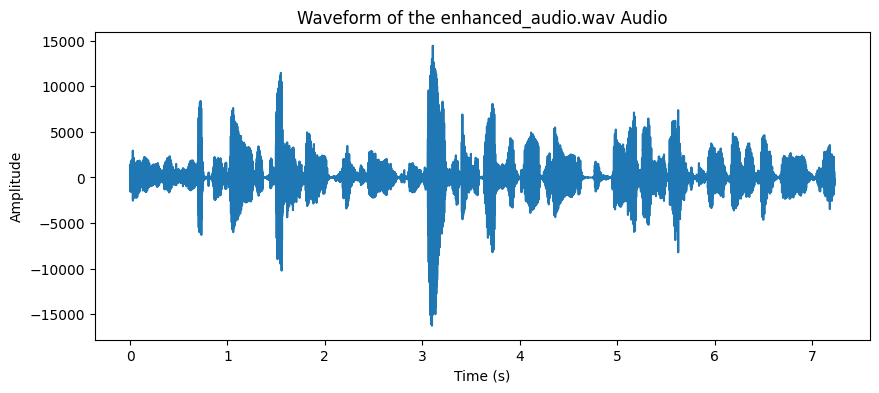

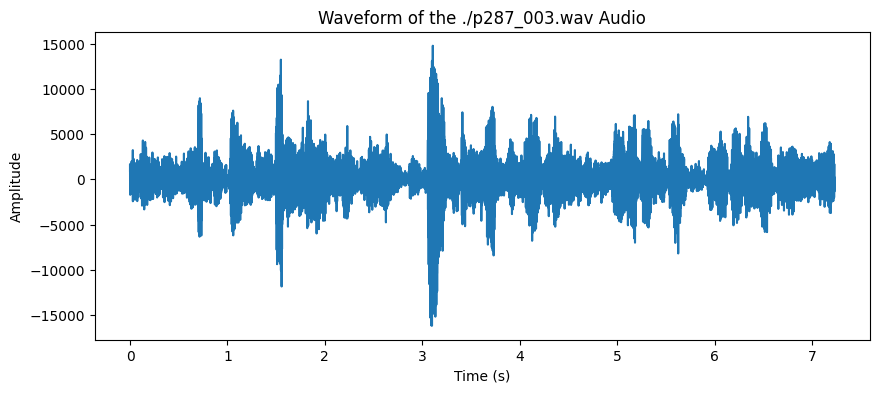

(None, None)

In [16]:
plot_graph(output_path), plot_graph(audio_path)

In [17]:
clean_audio, sample_rate_clean = read_wave_file(clean_audio_path)
enhanced_audio, sample_rate_enhanced = read_wave_file(output_path)

# Ensure both audios have the same sample rate
assert sample_rate_clean == sample_rate_enhanced, "Sample rates do not match!"

# Convert numpy arrays to PyTorch tensors
clean_audio_tensor = torch.from_numpy(clean_audio).float()
enhanced_audio_tensor = torch.from_numpy(enhanced_audio).float()

# Add batch dimension (required if used in neural network training or loss functions)
clean_audio_tensor = clean_audio_tensor.unsqueeze(0)
enhanced_audio_tensor = enhanced_audio_tensor.unsqueeze(0)

In [18]:
def si_sdr_loss(clean, enhanced):
    clean_energy = torch.sum(clean ** 2, dim=-1, keepdim=True)
    optimal_scaling = torch.sum(clean * enhanced, dim=-1, keepdim=True) / clean_energy
    projected_clean = optimal_scaling * clean
    noise = enhanced - projected_clean
    loss = 10 * torch.log10(torch.sum(projected_clean ** 2) / torch.sum(noise ** 2))
    return -loss  # We want to maximize SI-SDR, so return the negative


In [19]:
# Compute SI-SDR Loss
sdr_loss = si_sdr_loss(clean_audio_tensor, enhanced_audio_tensor)
loss = sdr_loss.item()                                                                                                                                                                                                                                                              *(-1)
print(f"SI-SDR Loss: {loss} dB")

SI-SDR Loss: 8.572694778442383 dB


Normalization

In [20]:
audio, sr = librosa.load(audio_path,sr=None)

In [21]:
normalized_audio = librosa.util.normalize(audio)

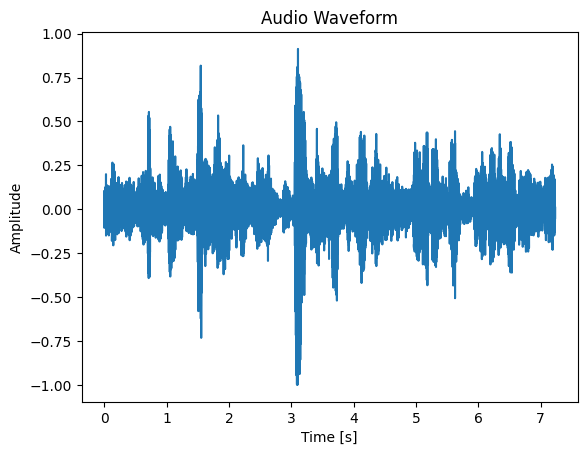

In [22]:
time = np.arange(0, len(normalized_audio)) / sr
plt.plot(time, normalized_audio)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Audio Waveform')
plt.show()

### SAMPLE

In [25]:
import soundfile as sf

# Load the MP3 file
audio_data, sample_rate = librosa.load("realrec_fileid_73.mp3", sr=None)

# Save the audio to a WAV file
sf.write("output.wav", audio_data, sample_rate)

In [27]:
load_audio("output.wav")

output.wav details:
Channels: 1
Sample width: 2
Frame rate (sample rate): 16000
Number of frames: 281600


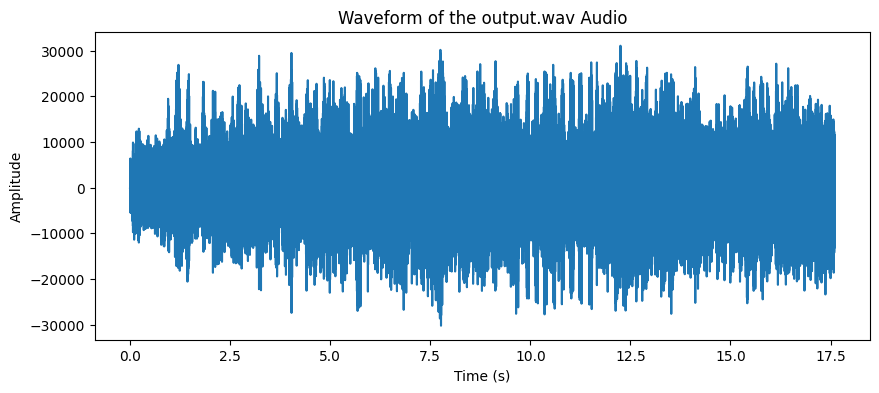

In [28]:
plot_graph("output.wav")

In [31]:
# Function to denoise the audio
def denoise_audio(model, noisy_waveform, sample_rate):
    # Convert the noisy waveform to tensor and add batch dimension
    noisy_waveform_tensor = torch.from_numpy(noisy_waveform).unsqueeze(0)
    
    # Denoise the audio using the pre-trained model
    with torch.no_grad():
        denoised_waveform_tensor = model(noisy_waveform_tensor)
    
    # Remove batch dimension and convert back to numpy array
    denoised_waveform_np = denoised_waveform_tensor.squeeze(0).numpy()
    
    return denoised_waveform_np

def process_denoise(audio_path, model, output_path):
    # Load the audio file
    noisy_waveform, sample_rate = read_wave_file(audio_path)
    
    # Denoise the audio
    denoised_waveform = denoise_audio(model, noisy_waveform, sample_rate)
    
    # Save the denoised audio to a new .wav file
    save_wave_file(output_path, denoised_waveform, sample_rate)

    return denoised_waveform

In [32]:
denoised_audio = process_denoise("output.wav", model, 'denoised_audio.wav')

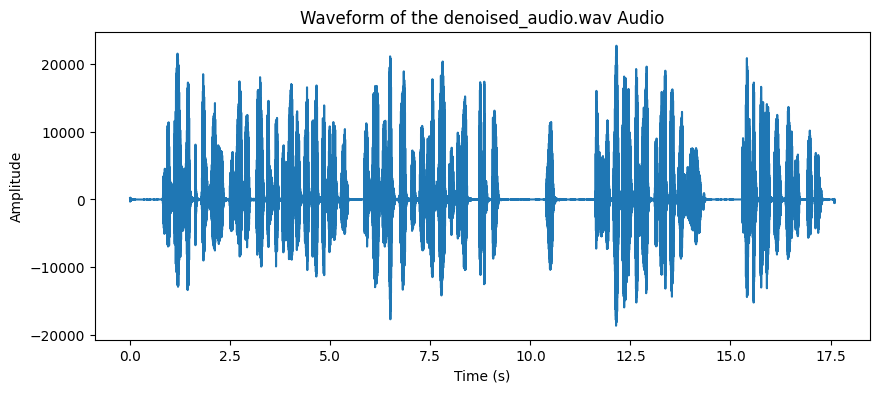

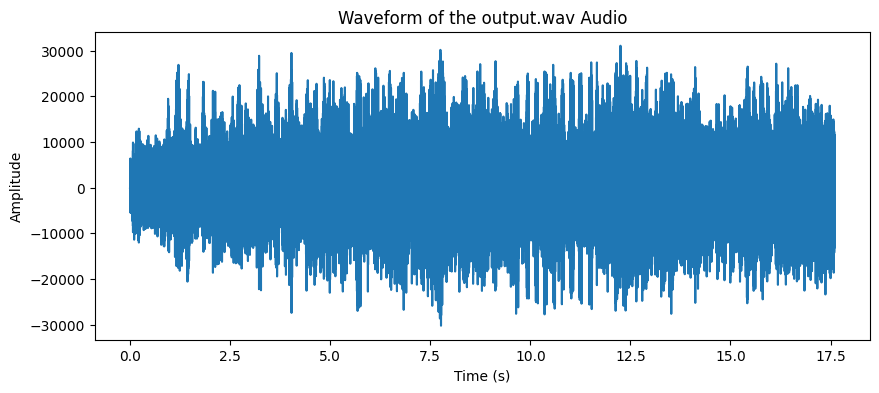

(None, None)

In [34]:
plot_graph('denoised_audio.wav'),plot_graph('output.wav')

In [36]:
from IPython.display import Audio, display
print("Original Audio:")
display(Audio("output.wav"))

print("Denoised Audio:")
display(Audio("denoised_audio.wav"))

Original Audio:


Denoised Audio:
